# Chapter 15: Processing Sequences Using RNNs and CNNs
This work is partialy combined text and code from the book [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) and is only supposed to be used as reference and recommended to follow along with a copy of the Book puchased. 

This chapter we will discuss recurrent neural networks (RNNs), a class of nets that can work on sequences of arbitrary lenghts, rather than on fixed-sized inputs.

After that we'll see two main difficulties that RNNs face:
- Unstable gradients and and techniques to resolve it
- A (very) limited short-term memory, which can be extended using LSTM and GRU cells.

And we'll end the chapter by implementing *WaveNet*.

# Recurrent Neurons and Layers
<mark>A recurrent neural network looks very much like a feedforward neural network, except is also has connections pointing backward.</mark>

At each *time step* $t$ (also called a *frame*), this *recurrent neuron* receives the inputs $x_{(i)}$ as well as its own output from the previous time step, $y_{(i-1)}$. Since there is no previous output at the first time step, it is generally set to 0. 

We can represent a tiny network against time, this is referred to as *unrolling network through time*.



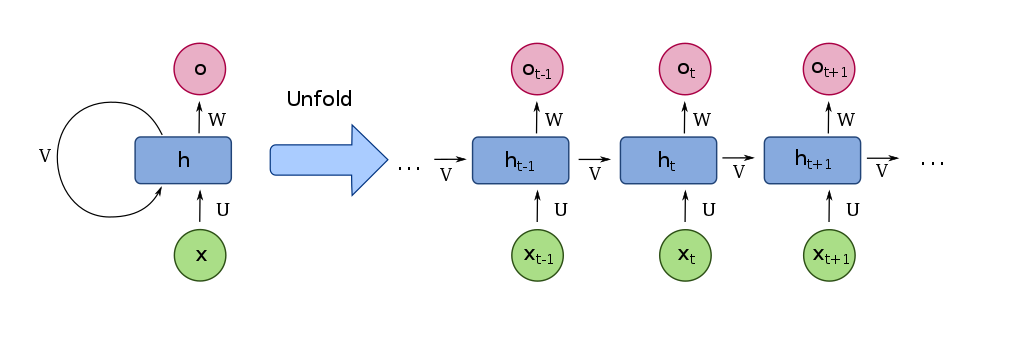

We can easily stack such neurons in a layer, which will recieve input vector $x_{(t)}$ and the output vector from the previous time step $y_{(t-1)}$.

Each recurrent neuron has two sets of weights:
- $w_x$ for the inputs
- $y{(t-1)}$ for the outputs of the previous time step.

If we consider the whole layer, then we're going to have $W_x$ and $W_y$.

*Equation 15-1. Ouput of a recurrent layer for a single instance*
$$y_{(y)}=\phi\big(W_x^\top x_{(t)}+W_y^\top y_{(y-1)} + b\big)$$

<mark>*Equation 15-2. Ouptuts of a layer of recurrent neurons for all instances in a mini-batch*
$$\begin{equation}\begin{split}Y_{(t)}&= \phi\big(X_{(t)}W_x + Y_{(t-1)}W_y+b \big)\\&=\phi\big(\big[X_{(t)}\quad Y_{(t-1)}\big]W+b\big)\text{   with     } W=\begin{bmatrix}W_x\\W_y\end{bmatrix}\end{split}\end{equation}	
$$</mark>

In this equation:
- $Y_{(t)}$ is a $m\times n_\text{neurons}$ matrix containing the layer's outputs at time step $t$.
- $X_{(t)}$ is an $m\times n_\text{inputs}$ matrix containing the inputs for all the instances.
- $W_x$ is an $n_\text{inputs}\times n_\text{neurons}$ matrix containing the connection weights for the inputs of the current time step.
- $W_y$ is an $n_\text{neurons}\times n_\text{neurons}$ matrix containing the connection weights for the outputs of the previous time step.
- $b$ is a vector of size $n_\text{neurons}$ containing each neuron's bias term.

**$Y_{(t)}$ is a function of all the inputs since time $t=0$**




## Memory Cells
<mark>A part of neural network that preserves some state across time steps is calles a *memory cell*.</mark>

Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, we cam say it has a form of *memory*.

- <mark>In general a cell's state at time step $t$, denoted $h_{(t)}$ (the "h" denotes "hidden"), is a function of some inputs at that time step and its state at the previous time step
$$h_{(t)}= f(h_{(t-1)}, x_{(t)})$$

- A cell's output at time step denoted $y_{(t)}$, is laso a function of the previous state and the current inputs. In the case of the basic cells, the ouput is simply equal to the state, but in more complex cells this is not always the case.

## Input and Output Sequences.
1. **Sequence-to-Sequence Network**

  An RNN can simultaneously take a set of inputs and produe a set of outputs.
  
  Useful for predicting tie series such as stock prices. 
  

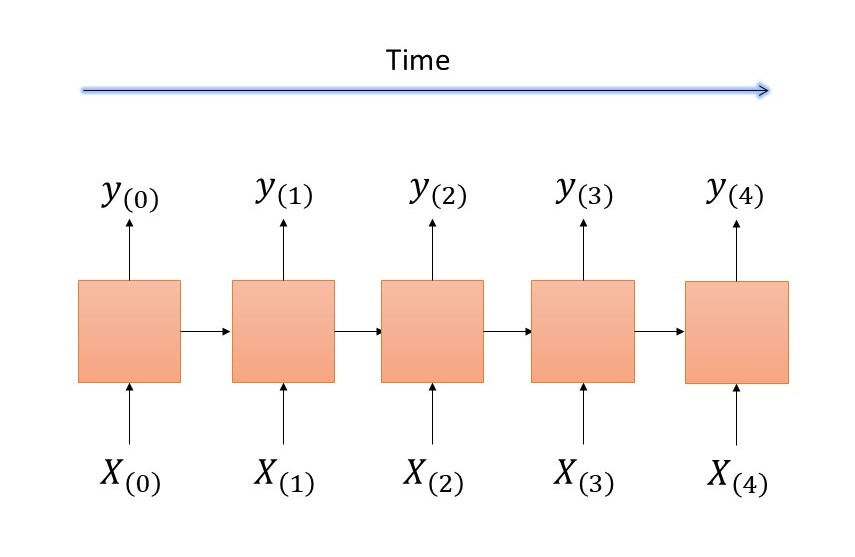

2. **Sequence-to-Vector network**

  When you feed a RNN a sequence of inputs and ignore all outputs except for the last one.

  For example you can use this type of network for outputing a sentiment score for a sequence of movie reviews.


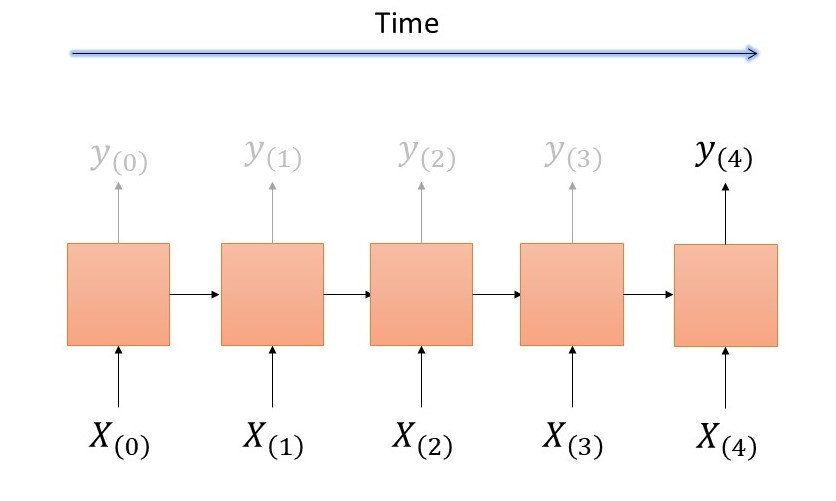

3. **Vector-to-Sequence network**

  When we feedd the RNN th same input vector over and over again at each time step and let it output a sequence.

  Like outputing captions for image.
  

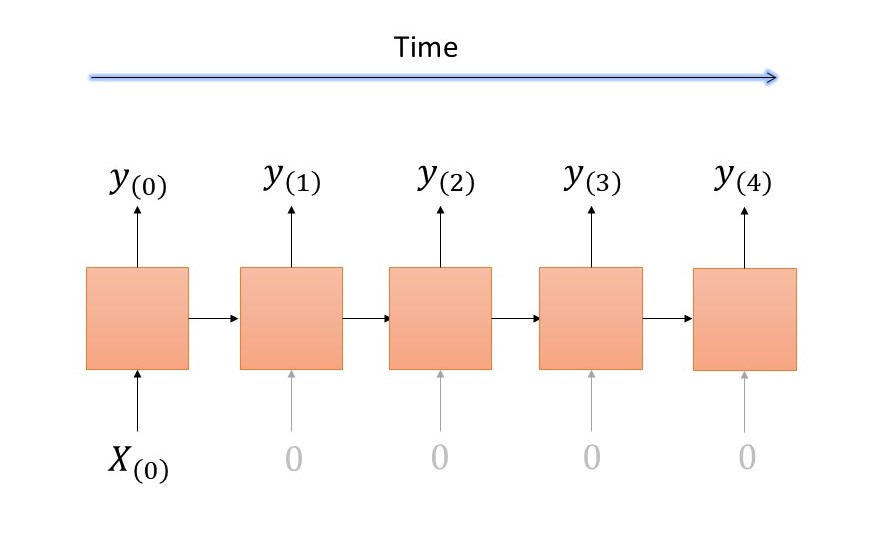

4. **Encoder-Decoder**

  You could have a sequence-to-vector network, called an *encoder*, followed by a vector-to-sequence network, called a *decoder*. This all set up is called Encoder-Decoder.

  This can be useful for translating a sentence (A sequence) from one language to another (another sequence).

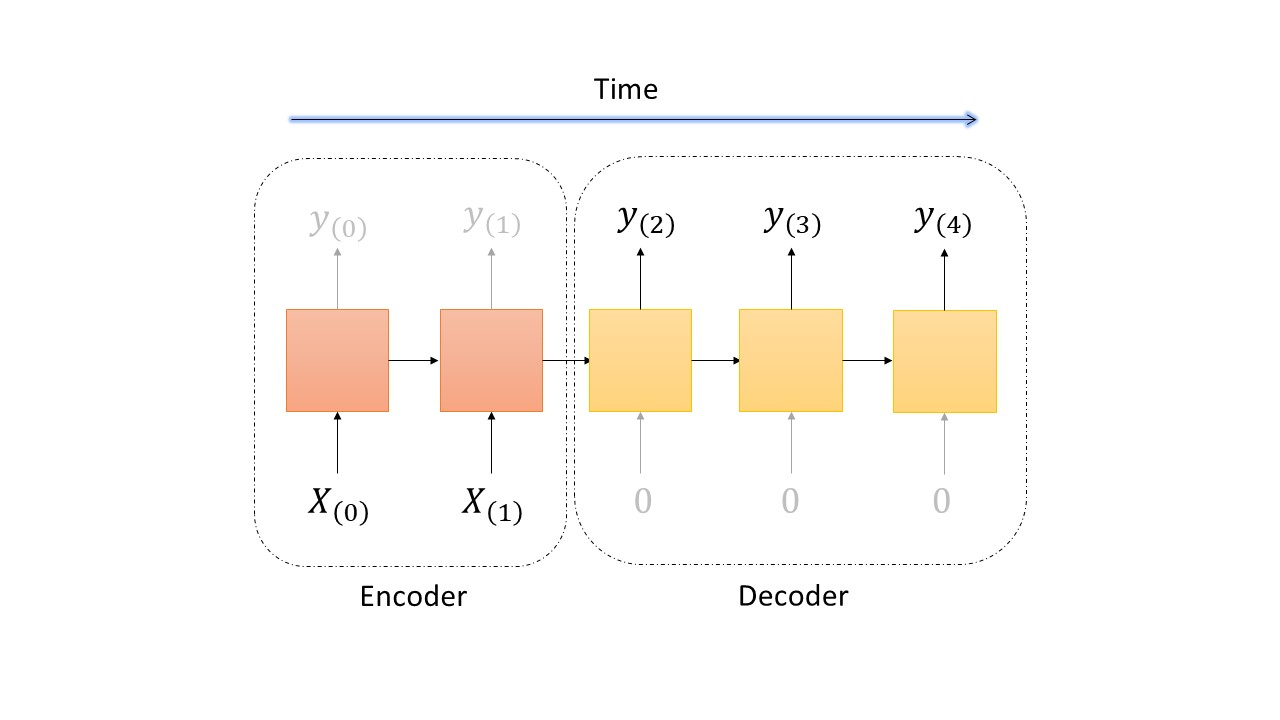

# Training RNNs
The trick is to unroll it through time and then simply use regular backpropagation. This strategy is called ***backpropagation through time*** (BPTT).
1. As usual forward pass through the unrolled network.
2. The output sequence is evaluated using a cost Function